In [1]:
from bs4 import BeautifulSoup as BS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import seaborn as sns
import requests

import warnings; warnings.simplefilter('ignore')

import re
from re import sub
import multiprocessing
from unidecode import unidecode

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors


from time import time 
from collections import defaultdict

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
import textblob

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.cluster import KMeans

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bibek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Collection

In [2]:
baseurl = "https://sokoglam.com"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36'}

In [3]:
k = requests.get('https://sokoglam.com/collections/skincare').text
soup=BS(k,'html.parser')
productlist = soup.find_all("div",{"class":"product-grid-item"})

In [4]:
productlinks = []
for product in productlist:
    link = product.find('a').get('href')
    productlinks.append(baseurl + link)

AttributeError: 'NoneType' object has no attribute 'get'

In [239]:
len(productlinks)

299

In [240]:
data=[]
for link in productlinks:
    f = requests.get(link,headers=headers).text
    hun=BS(f,'html.parser')
    try:
        i=hun.find("div",{"class":"review-stars"})
        product_id = i.find("div").get("data-product-id")
    except:
        product_id = None
        
    try:
        name=hun.find("h1",{"class":"pdp__product-title"}).text.replace('\n',"")
    except:
        name = None
        
    try:
        brand=hun.find("h3",{"class":"pdp__product-vendor"}).text.replace('\n',"")
    except:
        brand = None
    
    try:
        price=hun.find("span",{"class":"pdp-product__price--sale ProductPrice"}).text.replace('\n',"")
    except:
        price = None

    try:
        content1=hun.find("section",{"id":"content1"})
        descp=content1.find("div",{"class":"pdp-tab-content"}).text.replace('\n',"")
    except:
        descp = None

    product = {"product_ID":product_id,"product_name":name, "product_brand":brand, "price": price, "product_description":descp, }

    data.append(product)

In [408]:
meta_df = pd.DataFrame(data)

In [409]:
meta_df.shape

(299, 5)

Removing products that are either body or hair product, makeup products that is not typical skincare, books from the website, clothes

In [410]:
remove = ['Hair', 'Shampoo', 'Body', 'Foot', 'Hand']
for item in remove:
    for index, row in meta_df.iterrows():
        x = str(row['product_name'])
        if item in x:
            meta_df.drop(index, inplace=True)
        else:
            None

In [411]:
remove = ['Hair', 'Shampoo', 'Body', 'Foot', 'Hand']
for item in remove:
    for index, row in meta_df.iterrows():
        x = str(row['product_description'])
        if item in x:
            meta_df.drop(index, inplace=True)
        else:
            None

In [412]:
remove = ['Set', 'Kit', 'Routine', 'Collection', 'Duo Trial', 'Treatment Duo', 'Balancing Duo', 'Cleansing Duo']
for item in remove:
    for index, row in meta_df.iterrows():
        x = str(row['product_name'])
        if item in x:
            meta_df.drop(index, inplace=True)
        else:
            None

In [413]:
remove = ['Liner', 'Blush', 'Primer', 'Lip Luminizer', 'Lip Lacquer', 'Eyeliner']
for item in remove:
    for index, row in meta_df.iterrows():
        x = str(row['product_name'])
        if item in x:
            meta_df.drop(index, inplace=True)
        else:
            None

In [414]:
remove = ['Cotton', 'Paper', 'Book', 'Baseball Cap', 'Sweatshirt']
for item in remove:
    for index, row in meta_df.iterrows():
        x = str(row['product_name'])
        if item in x:
            meta_df.drop(index, inplace=True)
        else:
            None

In [415]:
meta_df.shape

(243, 5)

Adding a product type to the dataframe

In [416]:
meta_df['product_type'] = None

In [417]:
def product_type(items, word, df):
    for item in items:
        for index, row in df.iterrows():
            if row['product_type'] == None:
                x = str(row['product_name'])
                if item in x:
                    row['product_type'] = word
                else:
                    None

In [418]:
items = ['Eye']
product_type(items, 'Eye Treatment', meta_df)

In [419]:
items = ['Lip']
product_type(items, 'Lip Treatment', meta_df)

In [420]:
add = ['Sun Cream', 'Sun Essence', 'Sunscreen', 'UV', 'SPF', "I'm Safe For Sensitive Skin", 'Suncream']
for item in add:
    for index, row in meta_df.iterrows():
        if row['product_type'] == None:
            x = str(row['product_name'])
            if item in x:
                row['product_type'] = 'Sun Protection'
            else:
                None

In [421]:
items = ['Sheet Mask']
product_type(items, 'Sheet Mask', meta_df)

In [422]:
items = ['Mask']
product_type(items, 'Mask', meta_df)

In [423]:
items = ['Serum', 'Ampoule']
product_type(items, 'Serum', meta_df)

In [424]:
items = ['Essence', 'Mist']
product_type(items, 'Essence', meta_df)

In [425]:
items = ['Cleansing', 'Cleanser', 'Foam']
product_type(items, 'Cleanser', meta_df)

In [426]:
items = ['Toner', 'Toning', 'Water']
product_type(items, 'Toner', meta_df)

In [427]:
items = ['Lotion', 'Cream', 'Moisturizer', 'Emulsion']
product_type(items, 'Moisturizer', meta_df)

In [428]:
items = ['Peel', 'Peeling', 'Scrub', 'Exfoliat', 'Pad']
product_type(items, 'Exfoliator', meta_df)

In [429]:
for index, row in meta_df.iterrows():
    if row['product_type'] == None:
        x = str(row['product_name'])
        row['product_type'] = 'Other/Spot Treatments'

In [ ]:
meta_df.to_csv('productlist.csv')

In [ ]:
session = requests.Session()
#productToReviews = [] #empty dictionary
productReviews = []
for index, row in meta_df.iterrows():
    requestUrl = 'https://staticw2.yotpo.com/batch/app_key/kILjLgKH3AFJKWu0W8HoD8nuvs72obqsSPmWjHiG/domain_key/{}/widget/reviews'.format(row.product_ID)
    recordExists = True
    i = 1
    while(recordExists):
        methodBody = '[{"method":"reviews","params":{"pid":' + row.product_ID + ',"order_metadata_fields":{},"index":0,"element_id":"1","data_source":"default","page":' + str(i) +',"host-widget":"main_widget","is_mobile":false,"pictures_per_review":10}}]'
        #print(methodBody)
        x = session.post(url, data = {'methods': methodBody})
        if('be the first to write a review' in x.text):
            #print("no record")
            recordExists = False
        else:
            y = json.loads(x.text)
            soup=BS(y[0]["result"],'html.parser')
            reviewList = soup.find_all("div",{"class":"content-review"})
            for review in reviewList:
                s = BS(str(review),'html.parser')
                r = s.find("div").text.strip()
                if(len(r)):
                    productReviews.append({"product_id": row.product_ID, "review": r})
            i += 1
reviewDataFrame = pd.DataFrame.from_records(productReviews)

In [436]:
reviewDataFrame.to_csv('productReviews.csv')

### Data Preparation

In [3]:
Reviews_df = pd.read_csv("productReviews.csv")
productList_df = pd.read_csv("productlist.csv")

In [4]:
productList_df = productList_df.rename(columns={"product_ID": "product_id"})
productList_df = productList_df.iloc[: , 1:]

In [5]:
productList_df.head(2)

,product_id,product_name,product_brand,price,product_description,product_type
0,4680886255685,Pore Cleansing Balm AHA,HANSKIN,$22,"Designed for dry skin, this deep cleansing bal...",Cleanser
1,4680886288453,Pore Cleansing Balm BHA,HANSKIN,$22,"Designed for oily and acne-prone skin, this de...",Cleanser


In [6]:
Reviews_df = Reviews_df.iloc[: , 1:]
Reviews_df.head()

,product_id,review
0,4669755719749,This makes my skin smooth and soft and is ligh...
1,4669755719749,Love the silky texture. It's very lightweight ...
2,4669755719749,I’ve been trying to find a moisturizer that wo...
3,4669755719749,HYRAM made me buy it and I’m on my second bott...
4,4669755719749,It's a nice moisturizer I personally will use ...


In [7]:
productReviews_df = pd.merge(Reviews_df, productList_df, how="inner", on=["product_id"])

In [8]:
productReviews_df.shape

(15040, 7)

Remove Whitespace

In [9]:
def no_whitespace(string):
    return string.strip()

In [10]:
# stripping white space from all column type as object
def clean_string(df):
    
    for col in df.columns:
        if df[col].dtype == np.object:
            new = '{}_new'.format(col)
            df[new] = df[col].apply(no_whitespace)
            df[col] = df[new]
            df = df.drop(columns=[new])
    return df


productReviews_df = clean_string(productReviews_df)
productReviews_df.head(2)

,product_id,review,product_name,product_brand,price,product_description,product_type
0,4669755719749,This makes my skin smooth and soft and is ligh...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner
1,4669755719749,Love the silky texture. It's very lightweight ...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner


Customized Stopwords to keep the negative stopwords

In [11]:
stop = stopwords.words('english')
len(stop)

179

In [12]:
from itertools import groupby

In [13]:
# initializing char list 
char_list = ['against', 'no', 'nor', 'not', 'don', "don't", 'aren',"aren't", 'couldn', "couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'ma','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't", 'ain', "ain't"]
len(char_list)

43

In [14]:
# Remove words containing list characters
# using list comprehension + all()
res = [ele for ele in stop if all(ch not in ele for ch in char_list)]

In [15]:
def text_w_punc(text):
    pattern = r'[^A-Za-z ]'
    regex = re.compile(pattern)
    text = regex.sub(' ', text)
    return text

In [16]:
import string

In [17]:
def pre_processing(df, stop):
    # converting all text to lowercase
    df["review1"] = df["review"].str.lower()
    
    # removing punctuation using string.punctuations and join()
    df["review1"] = df["review1"].apply(lambda x: "".join([i for i in x if i not in string.punctuation]))
    df['review1'] = df['review1'].apply(lambda x: text_w_punc(x))    
    # remove stop words
    stop = res

    df['stopwords'] = df["review1"].apply(lambda x: len([i for i in x.split() if i in stop]))
    df["review1"]= df["review1"].apply(lambda x: " ".join(i for i in x.split() if i not in stop))
    df['stopwords'] = df['review1'].apply(lambda x: len([i for i in x.split() if i in stop]))
    del df['stopwords']
    return df


In [18]:
reviews_df = pre_processing(productReviews_df, res)

In [19]:
reviews_df.shape

(15040, 8)

In [20]:
remove = ['Hi ', 'hi ', 'sorry', 'Sorry']
for item in remove:
    for index, row in reviews_df.iterrows():
        x = str(row['review1'])
        if item in x:
            reviews_df.drop(index, inplace=True)
        else:
            None

In [21]:
reviews_df.shape

(14562, 8)

Lemmatization

In [22]:
from nltk import pos_tag

In [23]:
text_list = reviews_df['review1'].tolist()

tagged_texts = []

# tag each word
for text in text_list:
    text_tag = pos_tag(word_tokenize(text))
    tagged_texts.append(text_tag)

In [24]:
reviews_df['pos_tags'] = tagged_texts

In [25]:
reviews_df.head(3)

,product_id,review,product_name,product_brand,price,product_description,product_type,review1,pos_tags
0,4669755719749,This makes my skin smooth and soft and is ligh...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,makes skin smooth soft lightweight absorbs qui...,"[(makes, VBZ), (skin, JJ), (smooth, JJ), (soft..."
1,4669755719749,Love the silky texture. It's very lightweight ...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,love silky texture lightweight hydrating leave...,"[(love, VB), (silky, JJ), (texture, NN), (ligh..."
2,4669755719749,I’ve been trying to find a moisturizer that wo...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,trying find moisturizer would not dry skin mon...,"[(trying, VBG), (find, NN), (moisturizer, NN),..."


In [26]:
from nltk.corpus import wordnet
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bibek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
reviews_df['wordnet_pos'] = reviews_df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
reviews_df.head()

,product_id,review,product_name,product_brand,price,product_description,product_type,review1,pos_tags,wordnet_pos
0,4669755719749,This makes my skin smooth and soft and is ligh...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,makes skin smooth soft lightweight absorbs qui...,"[(makes, VBZ), (skin, JJ), (smooth, JJ), (soft...","[(makes, v), (skin, a), (smooth, a), (soft, a)..."
1,4669755719749,Love the silky texture. It's very lightweight ...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,love silky texture lightweight hydrating leave...,"[(love, VB), (silky, JJ), (texture, NN), (ligh...","[(love, v), (silky, a), (texture, n), (lightwe..."
2,4669755719749,I’ve been trying to find a moisturizer that wo...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,trying find moisturizer would not dry skin mon...,"[(trying, VBG), (find, NN), (moisturizer, NN),...","[(trying, v), (find, n), (moisturizer, n), (wo..."
3,4669755719749,HYRAM made me buy it and I’m on my second bott...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,hyram made buy second bottle love product plea...,"[(hyram, NN), (made, VBD), (buy, JJ), (second,...","[(hyram, n), (made, v), (buy, a), (second, a),..."
4,4669755719749,It's a nice moisturizer I personally will use ...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,nice moisturizer personally use gets cold outs...,"[(nice, JJ), (moisturizer, NN), (personally, R...","[(nice, a), (moisturizer, n), (personally, r),..."


In [28]:
wnl = WordNetLemmatizer()
reviews_df['lemmatized'] = reviews_df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
reviews_df.head()

,product_id,review,product_name,product_brand,price,product_description,product_type,review1,pos_tags,wordnet_pos,lemmatized
0,4669755719749,This makes my skin smooth and soft and is ligh...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,makes skin smooth soft lightweight absorbs qui...,"[(makes, VBZ), (skin, JJ), (smooth, JJ), (soft...","[(makes, v), (skin, a), (smooth, a), (soft, a)...","[make, skin, smooth, soft, lightweight, absorb..."
1,4669755719749,Love the silky texture. It's very lightweight ...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,love silky texture lightweight hydrating leave...,"[(love, VB), (silky, JJ), (texture, NN), (ligh...","[(love, v), (silky, a), (texture, n), (lightwe...","[love, silky, texture, lightweight, hydrate, l..."
2,4669755719749,I’ve been trying to find a moisturizer that wo...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,trying find moisturizer would not dry skin mon...,"[(trying, VBG), (find, NN), (moisturizer, NN),...","[(trying, v), (find, n), (moisturizer, n), (wo...","[try, find, moisturizer, would, not, dry, skin..."
3,4669755719749,HYRAM made me buy it and I’m on my second bott...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,hyram made buy second bottle love product plea...,"[(hyram, NN), (made, VBD), (buy, JJ), (second,...","[(hyram, n), (made, v), (buy, a), (second, a),...","[hyram, make, buy, second, bottle, love, produ..."
4,4669755719749,It's a nice moisturizer I personally will use ...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,nice moisturizer personally use gets cold outs...,"[(nice, JJ), (moisturizer, NN), (personally, R...","[(nice, a), (moisturizer, n), (personally, r),...","[nice, moisturizer, personally, use, get, cold..."


In [29]:
def listToString(s): 
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))

In [30]:
reviews_df["review_clean"]= reviews_df["lemmatized"].apply(lambda x: " ".join(i for i in x))

In [31]:
reviews_df.head()

,product_id,review,product_name,product_brand,price,product_description,product_type,review1,pos_tags,wordnet_pos,lemmatized,review_clean
0,4669755719749,This makes my skin smooth and soft and is ligh...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,makes skin smooth soft lightweight absorbs qui...,"[(makes, VBZ), (skin, JJ), (smooth, JJ), (soft...","[(makes, v), (skin, a), (smooth, a), (soft, a)...","[make, skin, smooth, soft, lightweight, absorb...",make skin smooth soft lightweight absorbs quickly
1,4669755719749,Love the silky texture. It's very lightweight ...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,love silky texture lightweight hydrating leave...,"[(love, VB), (silky, JJ), (texture, NN), (ligh...","[(love, v), (silky, a), (texture, n), (lightwe...","[love, silky, texture, lightweight, hydrate, l...",love silky texture lightweight hydrate leaf sk...
2,4669755719749,I’ve been trying to find a moisturizer that wo...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,trying find moisturizer would not dry skin mon...,"[(trying, VBG), (find, NN), (moisturizer, NN),...","[(trying, v), (find, n), (moisturizer, n), (wo...","[try, find, moisturizer, would, not, dry, skin...",try find moisturizer would not dry skin month ...
3,4669755719749,HYRAM made me buy it and I’m on my second bott...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,hyram made buy second bottle love product plea...,"[(hyram, NN), (made, VBD), (buy, JJ), (second,...","[(hyram, n), (made, v), (buy, a), (second, a),...","[hyram, make, buy, second, bottle, love, produ...",hyram make buy second bottle love product plea...
4,4669755719749,It's a nice moisturizer I personally will use ...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,nice moisturizer personally use gets cold outs...,"[(nice, JJ), (moisturizer, NN), (personally, R...","[(nice, a), (moisturizer, n), (personally, r),...","[nice, moisturizer, personally, use, get, cold...",nice moisturizer personally use get cold outsi...


In [32]:
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
features = reviews_df["review_clean"].tolist()

In [34]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
 
CountVec = CountVectorizer()
#transform
Count_data = CountVec.fit_transform(features)
 
#create dataframe
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names())

In [35]:
cv_dataframe.shape

(14562, 10770)

In [36]:
reviews_df.shape

(14562, 12)

merging data

In [37]:
reviews_df = reviews_df.reset_index(drop=True)

In [38]:
df_merged = reviews_df.merge(cv_dataframe, how='inner', left_index=True, right_index=True)

In [39]:
df_merged.shape

(14562, 10782)

In [40]:
CountVec.vocabulary_

{'make': 5429,
 'skin': 8560,
 'smooth': 8706,
 'soft': 8754,
 'lightweight': 5171,
 'absorbs': 36,
 'quickly': 7439,
 'love': 5334,
 'silky': 8500,
 'texture': 9523,
 'hydrate': 4372,
 'leaf': 5073,
 'feel': 3304,
 'also': 359,
 'no': 6151,
 'detectable': 2369,
 'fragrance': 3572,
 'big': 909,
 'win': 10543,
 'come': 1696,
 'cute': 2104,
 'little': 5243,
 'sticker': 9039,
 'inside': 4649,
 'box': 1064,
 'try': 9941,
 'find': 3366,
 'moisturizer': 5846,
 'would': 10639,
 'not': 6239,
 'dry': 2665,
 'month': 5886,
 'especially': 2965,
 'wear': 10424,
 'mask': 5506,
 'product': 7255,
 'much': 5944,
 'well': 10460,
 'lots': 5328,
 'others': 6525,
 'thank': 9546,
 'hyram': 4417,
 'buy': 1206,
 'second': 8210,
 'bottle': 1047,
 'please': 6986,
 'don': 2576,
 'ever': 3033,
 'get': 3771,
 'rid': 7912,
 'super': 9281,
 'light': 5152,
 'weight': 10447,
 'sink': 8526,
 'fast': 3265,
 'use': 10170,
 'day': 2159,
 'non': 6162,
 'sticky': 9044,
 'doesn': 2566,
 'smell': 8683,
 'wonderful': 10591,
 

In [41]:
df_merged.head(2)

,product_id,review_x,product_name,product_brand,price_x,product_description,product_type,review1,pos_tags,wordnet_pos,...,ziploc,zit,zitkilla,zits,zitsacne,zitspimples,zitsticka,zoe,zone,zoom
0,4669755719749,This makes my skin smooth and soft and is ligh...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,makes skin smooth soft lightweight absorbs qui...,"[(makes, VBZ), (skin, JJ), (smooth, JJ), (soft...","[(makes, v), (skin, a), (smooth, a), (soft, a)...",...,0,0,0,0,0,0,0,0,0,0
1,4669755719749,Love the silky texture. It's very lightweight ...,Lotus Water Cream,ROVECTIN,$20,This facial moisturizer not only deeply hydrat...,Toner,love silky texture lightweight hydrating leave...,"[(love, VB), (silky, JJ), (texture, NN), (ligh...","[(love, v), (silky, a), (texture, n), (lightwe...",...,0,0,0,0,0,0,0,0,0,0


Sentiment Analysis

In [42]:
# converting string into list of words for each comment
def text_to_list(text):
    text = unidecode(text)
    pattern = r'[^A-Za-z ]'
    regex = re.compile(pattern)
    text = regex.sub('', text).split(' ')
    return text

In [43]:
reviews_df = reviews_df.copy()
reviews_df['review_clean'] = reviews_df['review_clean'].apply(lambda x: text_to_list(x))

In [45]:
#extraction of phrases and bigram model
sent = [row for row in reviews_df['review_clean'] ]
phrases = Phrases(sent, min_count=1, progress_per=7)
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 03:35:39: collecting all words and their counts
INFO - 03:35:39: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 03:35:39: PROGRESS: at sentence #7, processed 124 words and 208 word types
INFO - 03:35:39: PROGRESS: at sentence #14, processed 241 words and 373 word types
INFO - 03:35:39: PROGRESS: at sentence #21, processed 349 words and 510 word types
INFO - 03:35:39: PROGRESS: at sentence #28, processed 577 words and 801 word types
INFO - 03:35:39: PROGRESS: at sentence #35, processed 705 words and 945 word types
INFO - 03:35:39: PROGRESS: at sentence #42, processed 984 words and 1264 word types
INFO - 03:35:39: PROGRESS: at sentence #49, processed 1210 words and 1553 word types
INFO - 03:35:39: PROGRESS: at sentence #56, processed 1358 words and 1724 word types
INFO - 03:35:39: PROGRESS: at sentence #63, processed 1496 words and 1876 word types
INFO - 03:35:39: PROGRESS: at sentence #70, processed 1707 words and 2109 word types
INFO - 03:35:39: PROGRESS: at

INFO - 03:35:39: PROGRESS: at sentence #658, processed 19317 words and 16168 word types
INFO - 03:35:39: PROGRESS: at sentence #665, processed 19435 words and 16236 word types
INFO - 03:35:39: PROGRESS: at sentence #672, processed 19595 words and 16310 word types
INFO - 03:35:39: PROGRESS: at sentence #679, processed 19701 words and 16373 word types
INFO - 03:35:39: PROGRESS: at sentence #686, processed 20019 words and 16613 word types
INFO - 03:35:39: PROGRESS: at sentence #693, processed 20165 words and 16726 word types
INFO - 03:35:39: PROGRESS: at sentence #700, processed 20442 words and 16897 word types
INFO - 03:35:39: PROGRESS: at sentence #707, processed 20584 words and 16968 word types
INFO - 03:35:39: PROGRESS: at sentence #714, processed 20724 words and 17044 word types
INFO - 03:35:39: PROGRESS: at sentence #721, processed 20856 words and 17123 word types
INFO - 03:35:39: PROGRESS: at sentence #728, processed 21103 words and 17273 word types
INFO - 03:35:39: PROGRESS: at se

INFO - 03:35:39: PROGRESS: at sentence #1309, processed 36712 words and 25962 word types
INFO - 03:35:39: PROGRESS: at sentence #1316, processed 36972 words and 26112 word types
INFO - 03:35:39: PROGRESS: at sentence #1323, processed 37163 words and 26181 word types
INFO - 03:35:39: PROGRESS: at sentence #1330, processed 37319 words and 26274 word types
INFO - 03:35:39: PROGRESS: at sentence #1337, processed 37446 words and 26319 word types
INFO - 03:35:39: PROGRESS: at sentence #1344, processed 37596 words and 26393 word types
INFO - 03:35:39: PROGRESS: at sentence #1351, processed 37770 words and 26479 word types
INFO - 03:35:39: PROGRESS: at sentence #1358, processed 38102 words and 26691 word types
INFO - 03:35:39: PROGRESS: at sentence #1365, processed 38228 words and 26746 word types
INFO - 03:35:39: PROGRESS: at sentence #1372, processed 38447 words and 26870 word types
INFO - 03:35:39: PROGRESS: at sentence #1379, processed 38616 words and 26946 word types
INFO - 03:35:39: PROG

INFO - 03:35:39: PROGRESS: at sentence #1960, processed 56485 words and 36077 word types
INFO - 03:35:39: PROGRESS: at sentence #1967, processed 56591 words and 36129 word types
INFO - 03:35:39: PROGRESS: at sentence #1974, processed 56835 words and 36255 word types
INFO - 03:35:39: PROGRESS: at sentence #1981, processed 57015 words and 36346 word types
INFO - 03:35:39: PROGRESS: at sentence #1988, processed 57271 words and 36498 word types
INFO - 03:35:39: PROGRESS: at sentence #1995, processed 57453 words and 36584 word types
INFO - 03:35:39: PROGRESS: at sentence #2002, processed 57543 words and 36635 word types
INFO - 03:35:39: PROGRESS: at sentence #2009, processed 57634 words and 36693 word types
INFO - 03:35:39: PROGRESS: at sentence #2016, processed 57724 words and 36753 word types
INFO - 03:35:39: PROGRESS: at sentence #2023, processed 57938 words and 36911 word types
INFO - 03:35:39: PROGRESS: at sentence #2030, processed 58133 words and 37032 word types
INFO - 03:35:39: PROG

INFO - 03:35:39: PROGRESS: at sentence #2611, processed 69646 words and 42960 word types
INFO - 03:35:39: PROGRESS: at sentence #2618, processed 69800 words and 43049 word types
INFO - 03:35:39: PROGRESS: at sentence #2625, processed 69956 words and 43130 word types
INFO - 03:35:39: PROGRESS: at sentence #2632, processed 70072 words and 43186 word types
INFO - 03:35:39: PROGRESS: at sentence #2639, processed 70273 words and 43301 word types
INFO - 03:35:39: PROGRESS: at sentence #2646, processed 70455 words and 43381 word types
INFO - 03:35:39: PROGRESS: at sentence #2653, processed 70615 words and 43448 word types
INFO - 03:35:39: PROGRESS: at sentence #2660, processed 70791 words and 43562 word types
INFO - 03:35:39: PROGRESS: at sentence #2667, processed 71025 words and 43701 word types
INFO - 03:35:39: PROGRESS: at sentence #2674, processed 71222 words and 43797 word types
INFO - 03:35:39: PROGRESS: at sentence #2681, processed 71407 words and 43888 word types
INFO - 03:35:39: PROG

INFO - 03:35:39: PROGRESS: at sentence #3262, processed 85800 words and 50867 word types
INFO - 03:35:39: PROGRESS: at sentence #3269, processed 85959 words and 50926 word types
INFO - 03:35:39: PROGRESS: at sentence #3276, processed 86141 words and 51010 word types
INFO - 03:35:39: PROGRESS: at sentence #3283, processed 86333 words and 51095 word types
INFO - 03:35:39: PROGRESS: at sentence #3290, processed 86509 words and 51175 word types
INFO - 03:35:39: PROGRESS: at sentence #3297, processed 86750 words and 51317 word types
INFO - 03:35:39: PROGRESS: at sentence #3304, processed 86927 words and 51396 word types
INFO - 03:35:39: PROGRESS: at sentence #3311, processed 87040 words and 51436 word types
INFO - 03:35:39: PROGRESS: at sentence #3318, processed 87215 words and 51501 word types
INFO - 03:35:39: PROGRESS: at sentence #3325, processed 87336 words and 51554 word types
INFO - 03:35:39: PROGRESS: at sentence #3332, processed 87495 words and 51616 word types
INFO - 03:35:39: PROG

INFO - 03:35:39: PROGRESS: at sentence #3906, processed 104785 words and 59877 word types
INFO - 03:35:39: PROGRESS: at sentence #3913, processed 104895 words and 59929 word types
INFO - 03:35:39: PROGRESS: at sentence #3920, processed 105149 words and 60017 word types
INFO - 03:35:39: PROGRESS: at sentence #3927, processed 105332 words and 60094 word types
INFO - 03:35:39: PROGRESS: at sentence #3934, processed 105528 words and 60180 word types
INFO - 03:35:39: PROGRESS: at sentence #3941, processed 105715 words and 60261 word types
INFO - 03:35:39: PROGRESS: at sentence #3948, processed 106048 words and 60394 word types
INFO - 03:35:39: PROGRESS: at sentence #3955, processed 106246 words and 60479 word types
INFO - 03:35:39: PROGRESS: at sentence #3962, processed 106454 words and 60561 word types
INFO - 03:35:39: PROGRESS: at sentence #3969, processed 106790 words and 60724 word types
INFO - 03:35:39: PROGRESS: at sentence #3976, processed 106968 words and 60799 word types
INFO - 03:

INFO - 03:35:40: PROGRESS: at sentence #4550, processed 121908 words and 67351 word types
INFO - 03:35:40: PROGRESS: at sentence #4557, processed 122054 words and 67409 word types
INFO - 03:35:40: PROGRESS: at sentence #4564, processed 122193 words and 67476 word types
INFO - 03:35:40: PROGRESS: at sentence #4571, processed 122458 words and 67610 word types
INFO - 03:35:40: PROGRESS: at sentence #4578, processed 122595 words and 67674 word types
INFO - 03:35:40: PROGRESS: at sentence #4585, processed 122764 words and 67747 word types
INFO - 03:35:40: PROGRESS: at sentence #4592, processed 122994 words and 67871 word types
INFO - 03:35:40: PROGRESS: at sentence #4599, processed 123284 words and 68038 word types
INFO - 03:35:40: PROGRESS: at sentence #4606, processed 123461 words and 68110 word types
INFO - 03:35:40: PROGRESS: at sentence #4613, processed 123657 words and 68198 word types
INFO - 03:35:40: PROGRESS: at sentence #4620, processed 123791 words and 68254 word types
INFO - 03:

INFO - 03:35:40: PROGRESS: at sentence #5194, processed 140320 words and 75066 word types
INFO - 03:35:40: PROGRESS: at sentence #5201, processed 140484 words and 75140 word types
INFO - 03:35:40: PROGRESS: at sentence #5208, processed 140605 words and 75189 word types
INFO - 03:35:40: PROGRESS: at sentence #5215, processed 140733 words and 75236 word types
INFO - 03:35:40: PROGRESS: at sentence #5222, processed 140885 words and 75285 word types
INFO - 03:35:40: PROGRESS: at sentence #5229, processed 141025 words and 75331 word types
INFO - 03:35:40: PROGRESS: at sentence #5236, processed 141221 words and 75429 word types
INFO - 03:35:40: PROGRESS: at sentence #5243, processed 141352 words and 75484 word types
INFO - 03:35:40: PROGRESS: at sentence #5250, processed 141497 words and 75531 word types
INFO - 03:35:40: PROGRESS: at sentence #5257, processed 141717 words and 75622 word types
INFO - 03:35:40: PROGRESS: at sentence #5264, processed 141989 words and 75753 word types
INFO - 03:

INFO - 03:35:40: PROGRESS: at sentence #5838, processed 157414 words and 83032 word types
INFO - 03:35:40: PROGRESS: at sentence #5845, processed 157581 words and 83087 word types
INFO - 03:35:40: PROGRESS: at sentence #5852, processed 157751 words and 83152 word types
INFO - 03:35:40: PROGRESS: at sentence #5859, processed 157932 words and 83223 word types
INFO - 03:35:40: PROGRESS: at sentence #5866, processed 158174 words and 83326 word types
INFO - 03:35:40: PROGRESS: at sentence #5873, processed 158295 words and 83366 word types
INFO - 03:35:40: PROGRESS: at sentence #5880, processed 158534 words and 83475 word types
INFO - 03:35:40: PROGRESS: at sentence #5887, processed 158696 words and 83548 word types
INFO - 03:35:40: PROGRESS: at sentence #5894, processed 158830 words and 83599 word types
INFO - 03:35:40: PROGRESS: at sentence #5901, processed 159073 words and 83719 word types
INFO - 03:35:40: PROGRESS: at sentence #5908, processed 159179 words and 83737 word types
INFO - 03:

INFO - 03:35:40: PROGRESS: at sentence #6482, processed 176409 words and 90430 word types
INFO - 03:35:40: PROGRESS: at sentence #6489, processed 176584 words and 90487 word types
INFO - 03:35:40: PROGRESS: at sentence #6496, processed 176793 words and 90548 word types
INFO - 03:35:40: PROGRESS: at sentence #6503, processed 176965 words and 90621 word types
INFO - 03:35:40: PROGRESS: at sentence #6510, processed 177102 words and 90659 word types
INFO - 03:35:40: PROGRESS: at sentence #6517, processed 177690 words and 91024 word types
INFO - 03:35:40: PROGRESS: at sentence #6524, processed 177958 words and 91130 word types
INFO - 03:35:40: PROGRESS: at sentence #6531, processed 178182 words and 91229 word types
INFO - 03:35:40: PROGRESS: at sentence #6538, processed 178363 words and 91294 word types
INFO - 03:35:40: PROGRESS: at sentence #6545, processed 178609 words and 91393 word types
INFO - 03:35:40: PROGRESS: at sentence #6552, processed 178889 words and 91512 word types
INFO - 03:

INFO - 03:35:40: PROGRESS: at sentence #7126, processed 194219 words and 97405 word types
INFO - 03:35:40: PROGRESS: at sentence #7133, processed 194450 words and 97455 word types
INFO - 03:35:40: PROGRESS: at sentence #7140, processed 194664 words and 97537 word types
INFO - 03:35:40: PROGRESS: at sentence #7147, processed 194875 words and 97606 word types
INFO - 03:35:40: PROGRESS: at sentence #7154, processed 194988 words and 97638 word types
INFO - 03:35:40: PROGRESS: at sentence #7161, processed 195175 words and 97710 word types
INFO - 03:35:40: PROGRESS: at sentence #7168, processed 195381 words and 97773 word types
INFO - 03:35:40: PROGRESS: at sentence #7175, processed 195777 words and 97931 word types
INFO - 03:35:40: PROGRESS: at sentence #7182, processed 195873 words and 97947 word types
INFO - 03:35:40: PROGRESS: at sentence #7189, processed 196031 words and 98020 word types
INFO - 03:35:40: PROGRESS: at sentence #7196, processed 196151 words and 98044 word types
INFO - 03:

INFO - 03:35:40: PROGRESS: at sentence #7763, processed 212715 words and 104341 word types
INFO - 03:35:40: PROGRESS: at sentence #7770, processed 212914 words and 104413 word types
INFO - 03:35:40: PROGRESS: at sentence #7777, processed 213085 words and 104486 word types
INFO - 03:35:40: PROGRESS: at sentence #7784, processed 213223 words and 104542 word types
INFO - 03:35:40: PROGRESS: at sentence #7791, processed 213529 words and 104682 word types
INFO - 03:35:40: PROGRESS: at sentence #7798, processed 213694 words and 104755 word types
INFO - 03:35:40: PROGRESS: at sentence #7805, processed 213807 words and 104806 word types
INFO - 03:35:40: PROGRESS: at sentence #7812, processed 213949 words and 104842 word types
INFO - 03:35:40: PROGRESS: at sentence #7819, processed 214095 words and 104899 word types
INFO - 03:35:40: PROGRESS: at sentence #7826, processed 214227 words and 104950 word types
INFO - 03:35:40: PROGRESS: at sentence #7833, processed 214329 words and 104969 word types

INFO - 03:35:40: PROGRESS: at sentence #8400, processed 225749 words and 109095 word types
INFO - 03:35:40: PROGRESS: at sentence #8407, processed 225912 words and 109136 word types
INFO - 03:35:40: PROGRESS: at sentence #8414, processed 226237 words and 109262 word types
INFO - 03:35:40: PROGRESS: at sentence #8421, processed 226370 words and 109302 word types
INFO - 03:35:40: PROGRESS: at sentence #8428, processed 226499 words and 109345 word types
INFO - 03:35:40: PROGRESS: at sentence #8435, processed 226674 words and 109416 word types
INFO - 03:35:40: PROGRESS: at sentence #8442, processed 226808 words and 109453 word types
INFO - 03:35:40: PROGRESS: at sentence #8449, processed 226945 words and 109494 word types
INFO - 03:35:40: PROGRESS: at sentence #8456, processed 227134 words and 109551 word types
INFO - 03:35:40: PROGRESS: at sentence #8463, processed 227332 words and 109617 word types
INFO - 03:35:40: PROGRESS: at sentence #8470, processed 227454 words and 109650 word types

INFO - 03:35:40: PROGRESS: at sentence #9037, processed 241767 words and 114416 word types
INFO - 03:35:40: PROGRESS: at sentence #9044, processed 241886 words and 114445 word types
INFO - 03:35:40: PROGRESS: at sentence #9051, processed 242077 words and 114528 word types
INFO - 03:35:40: PROGRESS: at sentence #9058, processed 242209 words and 114588 word types
INFO - 03:35:40: PROGRESS: at sentence #9065, processed 242594 words and 114759 word types
INFO - 03:35:40: PROGRESS: at sentence #9072, processed 242794 words and 114839 word types
INFO - 03:35:40: PROGRESS: at sentence #9079, processed 242990 words and 114911 word types
INFO - 03:35:40: PROGRESS: at sentence #9086, processed 243191 words and 115002 word types
INFO - 03:35:40: PROGRESS: at sentence #9093, processed 243397 words and 115087 word types
INFO - 03:35:40: PROGRESS: at sentence #9100, processed 243672 words and 115173 word types
INFO - 03:35:40: PROGRESS: at sentence #9107, processed 243877 words and 115236 word types

INFO - 03:35:40: PROGRESS: at sentence #9674, processed 257948 words and 119734 word types
INFO - 03:35:40: PROGRESS: at sentence #9681, processed 258048 words and 119756 word types
INFO - 03:35:40: PROGRESS: at sentence #9688, processed 258179 words and 119794 word types
INFO - 03:35:40: PROGRESS: at sentence #9695, processed 258277 words and 119820 word types
INFO - 03:35:40: PROGRESS: at sentence #9702, processed 258393 words and 119857 word types
INFO - 03:35:40: PROGRESS: at sentence #9709, processed 258545 words and 119908 word types
INFO - 03:35:40: PROGRESS: at sentence #9716, processed 258631 words and 119925 word types
INFO - 03:35:40: PROGRESS: at sentence #9723, processed 258758 words and 119956 word types
INFO - 03:35:40: PROGRESS: at sentence #9730, processed 259103 words and 120111 word types
INFO - 03:35:40: PROGRESS: at sentence #9737, processed 259394 words and 120260 word types
INFO - 03:35:40: PROGRESS: at sentence #9744, processed 259621 words and 120329 word types

INFO - 03:35:40: PROGRESS: at sentence #10304, processed 274854 words and 126327 word types
INFO - 03:35:40: PROGRESS: at sentence #10311, processed 275101 words and 126438 word types
INFO - 03:35:40: PROGRESS: at sentence #10318, processed 275505 words and 126606 word types
INFO - 03:35:40: PROGRESS: at sentence #10325, processed 275650 words and 126661 word types
INFO - 03:35:40: PROGRESS: at sentence #10332, processed 275780 words and 126697 word types
INFO - 03:35:40: PROGRESS: at sentence #10339, processed 276015 words and 126786 word types
INFO - 03:35:40: PROGRESS: at sentence #10346, processed 276213 words and 126859 word types
INFO - 03:35:40: PROGRESS: at sentence #10353, processed 276444 words and 126948 word types
INFO - 03:35:40: PROGRESS: at sentence #10360, processed 276686 words and 127007 word types
INFO - 03:35:40: PROGRESS: at sentence #10367, processed 276911 words and 127084 word types
INFO - 03:35:40: PROGRESS: at sentence #10374, processed 277008 words and 127107

INFO - 03:35:40: PROGRESS: at sentence #10934, processed 293609 words and 132552 word types
INFO - 03:35:40: PROGRESS: at sentence #10941, processed 293777 words and 132586 word types
INFO - 03:35:40: PROGRESS: at sentence #10948, processed 293961 words and 132650 word types
INFO - 03:35:40: PROGRESS: at sentence #10955, processed 294097 words and 132704 word types
INFO - 03:35:40: PROGRESS: at sentence #10962, processed 294208 words and 132737 word types
INFO - 03:35:40: PROGRESS: at sentence #10969, processed 294462 words and 132818 word types
INFO - 03:35:40: PROGRESS: at sentence #10976, processed 294616 words and 132875 word types
INFO - 03:35:40: PROGRESS: at sentence #10983, processed 294915 words and 132996 word types
INFO - 03:35:40: PROGRESS: at sentence #10990, processed 295062 words and 133039 word types
INFO - 03:35:40: PROGRESS: at sentence #10997, processed 295228 words and 133106 word types
INFO - 03:35:40: PROGRESS: at sentence #11004, processed 295392 words and 133143

INFO - 03:35:40: PROGRESS: at sentence #11564, processed 307776 words and 137390 word types
INFO - 03:35:40: PROGRESS: at sentence #11571, processed 307917 words and 137431 word types
INFO - 03:35:40: PROGRESS: at sentence #11578, processed 308015 words and 137464 word types
INFO - 03:35:40: PROGRESS: at sentence #11585, processed 308153 words and 137523 word types
INFO - 03:35:40: PROGRESS: at sentence #11592, processed 308344 words and 137582 word types
INFO - 03:35:40: PROGRESS: at sentence #11599, processed 308524 words and 137640 word types
INFO - 03:35:40: PROGRESS: at sentence #11606, processed 308653 words and 137686 word types
INFO - 03:35:40: PROGRESS: at sentence #11613, processed 308796 words and 137733 word types
INFO - 03:35:40: PROGRESS: at sentence #11620, processed 308910 words and 137756 word types
INFO - 03:35:40: PROGRESS: at sentence #11627, processed 309053 words and 137799 word types
INFO - 03:35:40: PROGRESS: at sentence #11634, processed 309100 words and 137813

INFO - 03:35:40: PROGRESS: at sentence #12194, processed 322228 words and 141974 word types
INFO - 03:35:40: PROGRESS: at sentence #12201, processed 322358 words and 142005 word types
INFO - 03:35:40: PROGRESS: at sentence #12208, processed 322526 words and 142064 word types
INFO - 03:35:40: PROGRESS: at sentence #12215, processed 322644 words and 142105 word types
INFO - 03:35:40: PROGRESS: at sentence #12222, processed 322847 words and 142161 word types
INFO - 03:35:40: PROGRESS: at sentence #12229, processed 322934 words and 142183 word types
INFO - 03:35:40: PROGRESS: at sentence #12236, processed 323137 words and 142240 word types
INFO - 03:35:40: PROGRESS: at sentence #12243, processed 323233 words and 142264 word types
INFO - 03:35:40: PROGRESS: at sentence #12250, processed 323404 words and 142303 word types
INFO - 03:35:40: PROGRESS: at sentence #12257, processed 323676 words and 142374 word types
INFO - 03:35:40: PROGRESS: at sentence #12264, processed 323803 words and 142421

INFO - 03:35:40: PROGRESS: at sentence #12824, processed 337528 words and 146610 word types
INFO - 03:35:40: PROGRESS: at sentence #12831, processed 337744 words and 146666 word types
INFO - 03:35:40: PROGRESS: at sentence #12838, processed 337924 words and 146726 word types
INFO - 03:35:40: PROGRESS: at sentence #12845, processed 338127 words and 146795 word types
INFO - 03:35:40: PROGRESS: at sentence #12852, processed 338370 words and 146889 word types
INFO - 03:35:40: PROGRESS: at sentence #12859, processed 338530 words and 146936 word types
INFO - 03:35:40: PROGRESS: at sentence #12866, processed 338656 words and 146976 word types
INFO - 03:35:40: PROGRESS: at sentence #12873, processed 338820 words and 147021 word types
INFO - 03:35:40: PROGRESS: at sentence #12880, processed 339015 words and 147070 word types
INFO - 03:35:40: PROGRESS: at sentence #12887, processed 339178 words and 147110 word types
INFO - 03:35:40: PROGRESS: at sentence #12894, processed 339403 words and 147198

INFO - 03:35:40: PROGRESS: at sentence #13454, processed 352922 words and 151302 word types
INFO - 03:35:40: PROGRESS: at sentence #13461, processed 353225 words and 151436 word types
INFO - 03:35:40: PROGRESS: at sentence #13468, processed 353332 words and 151475 word types
INFO - 03:35:40: PROGRESS: at sentence #13475, processed 353429 words and 151500 word types
INFO - 03:35:40: PROGRESS: at sentence #13482, processed 353741 words and 151644 word types
INFO - 03:35:40: PROGRESS: at sentence #13489, processed 353916 words and 151715 word types
INFO - 03:35:40: PROGRESS: at sentence #13496, processed 354014 words and 151752 word types
INFO - 03:35:40: PROGRESS: at sentence #13503, processed 354206 words and 151832 word types
INFO - 03:35:40: PROGRESS: at sentence #13510, processed 354368 words and 151890 word types
INFO - 03:35:40: PROGRESS: at sentence #13517, processed 354597 words and 152017 word types
INFO - 03:35:40: PROGRESS: at sentence #13524, processed 354895 words and 152141

INFO - 03:35:40: PROGRESS: at sentence #14084, processed 369490 words and 156984 word types
INFO - 03:35:40: PROGRESS: at sentence #14091, processed 369620 words and 157025 word types
INFO - 03:35:40: PROGRESS: at sentence #14098, processed 369832 words and 157069 word types
INFO - 03:35:40: PROGRESS: at sentence #14105, processed 370014 words and 157121 word types
INFO - 03:35:40: PROGRESS: at sentence #14112, processed 370182 words and 157162 word types
INFO - 03:35:40: PROGRESS: at sentence #14119, processed 370265 words and 157181 word types
INFO - 03:35:40: PROGRESS: at sentence #14126, processed 370368 words and 157203 word types
INFO - 03:35:40: PROGRESS: at sentence #14133, processed 370466 words and 157215 word types
INFO - 03:35:40: PROGRESS: at sentence #14140, processed 370597 words and 157245 word types
INFO - 03:35:40: PROGRESS: at sentence #14147, processed 370727 words and 157278 word types
INFO - 03:35:40: PROGRESS: at sentence #14154, processed 370875 words and 157331

In [46]:
w2v_model = Word2Vec(min_count=1, size=2)

# building vocab
w2v_model.build_vocab(sentences, progress_per=20)

WARNING - 03:36:27: consider setting layer size to a multiple of 4 for greater performance
INFO - 03:36:27: collecting all words and their counts
INFO - 03:36:27: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 03:36:27: PROGRESS: at sentence #20, processed 307 words, keeping 185 word types
INFO - 03:36:27: PROGRESS: at sentence #40, processed 833 words, keeping 390 word types
INFO - 03:36:27: PROGRESS: at sentence #60, processed 1304 words, keeping 578 word types
INFO - 03:36:27: PROGRESS: at sentence #80, processed 1757 words, keeping 729 word types
INFO - 03:36:27: PROGRESS: at sentence #100, processed 2425 words, keeping 936 word types
INFO - 03:36:27: PROGRESS: at sentence #120, processed 3362 words, keeping 1198 word types
INFO - 03:36:27: PROGRESS: at sentence #140, processed 3892 words, keeping 1323 word types
INFO - 03:36:27: PROGRESS: at sentence #160, processed 4385 words, keeping 1417 word types
INFO - 03:36:27: PROGRESS: at sentence #180, processed

INFO - 03:36:27: PROGRESS: at sentence #1760, processed 44833 words, keeping 5643 word types
INFO - 03:36:27: PROGRESS: at sentence #1780, processed 45349 words, keeping 5676 word types
INFO - 03:36:27: PROGRESS: at sentence #1800, processed 45801 words, keeping 5705 word types
INFO - 03:36:27: PROGRESS: at sentence #1820, processed 46126 words, keeping 5724 word types
INFO - 03:36:27: PROGRESS: at sentence #1840, processed 46578 words, keeping 5755 word types
INFO - 03:36:27: PROGRESS: at sentence #1860, processed 46947 words, keeping 5781 word types
INFO - 03:36:27: PROGRESS: at sentence #1880, processed 47365 words, keeping 5809 word types
INFO - 03:36:27: PROGRESS: at sentence #1900, processed 47780 words, keeping 5839 word types
INFO - 03:36:27: PROGRESS: at sentence #1920, processed 48244 words, keeping 5875 word types
INFO - 03:36:27: PROGRESS: at sentence #1940, processed 48620 words, keeping 5885 word types
INFO - 03:36:27: PROGRESS: at sentence #1960, processed 49101 words, k

INFO - 03:36:27: PROGRESS: at sentence #3540, processed 81499 words, keeping 7975 word types
INFO - 03:36:27: PROGRESS: at sentence #3560, processed 81928 words, keeping 8004 word types
INFO - 03:36:27: PROGRESS: at sentence #3580, processed 82425 words, keeping 8033 word types
INFO - 03:36:27: PROGRESS: at sentence #3600, processed 82907 words, keeping 8068 word types
INFO - 03:36:27: PROGRESS: at sentence #3620, processed 83416 words, keeping 8084 word types
INFO - 03:36:27: PROGRESS: at sentence #3640, processed 83868 words, keeping 8103 word types
INFO - 03:36:27: PROGRESS: at sentence #3660, processed 84376 words, keeping 8123 word types
INFO - 03:36:27: PROGRESS: at sentence #3680, processed 84873 words, keeping 8151 word types
INFO - 03:36:27: PROGRESS: at sentence #3700, processed 85339 words, keeping 8171 word types
INFO - 03:36:27: PROGRESS: at sentence #3720, processed 85916 words, keeping 8215 word types
INFO - 03:36:27: PROGRESS: at sentence #3740, processed 86547 words, k

INFO - 03:36:27: PROGRESS: at sentence #5300, processed 125322 words, keeping 10004 word types
INFO - 03:36:27: PROGRESS: at sentence #5320, processed 125829 words, keeping 10030 word types
INFO - 03:36:27: PROGRESS: at sentence #5340, processed 126360 words, keeping 10049 word types
INFO - 03:36:27: PROGRESS: at sentence #5360, processed 126918 words, keeping 10080 word types
INFO - 03:36:27: PROGRESS: at sentence #5380, processed 127493 words, keeping 10102 word types
INFO - 03:36:28: PROGRESS: at sentence #5400, processed 128067 words, keeping 10143 word types
INFO - 03:36:28: PROGRESS: at sentence #5420, processed 128563 words, keeping 10164 word types
INFO - 03:36:28: PROGRESS: at sentence #5440, processed 129167 words, keeping 10189 word types
INFO - 03:36:28: PROGRESS: at sentence #5460, processed 129548 words, keeping 10202 word types
INFO - 03:36:28: PROGRESS: at sentence #5480, processed 130298 words, keeping 10219 word types
INFO - 03:36:28: PROGRESS: at sentence #5500, proc

INFO - 03:36:28: PROGRESS: at sentence #7040, processed 168152 words, keeping 11870 word types
INFO - 03:36:28: PROGRESS: at sentence #7060, processed 168642 words, keeping 11879 word types
INFO - 03:36:28: PROGRESS: at sentence #7080, processed 169157 words, keeping 11892 word types
INFO - 03:36:28: PROGRESS: at sentence #7100, processed 169730 words, keeping 11901 word types
INFO - 03:36:28: PROGRESS: at sentence #7120, processed 170232 words, keeping 11910 word types
INFO - 03:36:28: PROGRESS: at sentence #7140, processed 170788 words, keeping 11924 word types
INFO - 03:36:28: PROGRESS: at sentence #7160, processed 171209 words, keeping 11939 word types
INFO - 03:36:28: PROGRESS: at sentence #7180, processed 171819 words, keeping 11952 word types
INFO - 03:36:28: PROGRESS: at sentence #7200, processed 172270 words, keeping 11965 word types
INFO - 03:36:28: PROGRESS: at sentence #7220, processed 173024 words, keeping 11987 word types
INFO - 03:36:28: PROGRESS: at sentence #7240, proc

INFO - 03:36:28: PROGRESS: at sentence #8780, processed 206909 words, keeping 13051 word types
INFO - 03:36:28: PROGRESS: at sentence #8800, processed 207283 words, keeping 13061 word types
INFO - 03:36:28: PROGRESS: at sentence #8820, processed 207716 words, keeping 13069 word types
INFO - 03:36:28: PROGRESS: at sentence #8840, processed 208053 words, keeping 13077 word types
INFO - 03:36:28: PROGRESS: at sentence #8860, processed 208453 words, keeping 13085 word types
INFO - 03:36:28: PROGRESS: at sentence #8880, processed 208899 words, keeping 13095 word types
INFO - 03:36:28: PROGRESS: at sentence #8900, processed 209280 words, keeping 13105 word types
INFO - 03:36:28: PROGRESS: at sentence #8920, processed 209798 words, keeping 13113 word types
INFO - 03:36:28: PROGRESS: at sentence #8940, processed 210216 words, keeping 13118 word types
INFO - 03:36:28: PROGRESS: at sentence #8960, processed 210735 words, keeping 13132 word types
INFO - 03:36:28: PROGRESS: at sentence #8980, proc

INFO - 03:36:28: PROGRESS: at sentence #10500, processed 246901 words, keeping 14195 word types
INFO - 03:36:28: PROGRESS: at sentence #10520, processed 247485 words, keeping 14204 word types
INFO - 03:36:28: PROGRESS: at sentence #10540, processed 248128 words, keeping 14237 word types
INFO - 03:36:28: PROGRESS: at sentence #10560, processed 248577 words, keeping 14241 word types
INFO - 03:36:28: PROGRESS: at sentence #10580, processed 248935 words, keeping 14246 word types
INFO - 03:36:28: PROGRESS: at sentence #10600, processed 249560 words, keeping 14261 word types
INFO - 03:36:28: PROGRESS: at sentence #10620, processed 250269 words, keeping 14302 word types
INFO - 03:36:28: PROGRESS: at sentence #10640, processed 250954 words, keeping 14315 word types
INFO - 03:36:28: PROGRESS: at sentence #10660, processed 251673 words, keeping 14334 word types
INFO - 03:36:28: PROGRESS: at sentence #10680, processed 252003 words, keeping 14341 word types
INFO - 03:36:28: PROGRESS: at sentence #

INFO - 03:36:28: PROGRESS: at sentence #12220, processed 283598 words, keeping 15118 word types
INFO - 03:36:28: PROGRESS: at sentence #12240, processed 283919 words, keeping 15128 word types
INFO - 03:36:28: PROGRESS: at sentence #12260, processed 284376 words, keeping 15133 word types
INFO - 03:36:28: PROGRESS: at sentence #12280, processed 284716 words, keeping 15143 word types
INFO - 03:36:28: PROGRESS: at sentence #12300, processed 285037 words, keeping 15149 word types
INFO - 03:36:28: PROGRESS: at sentence #12320, processed 285347 words, keeping 15154 word types
INFO - 03:36:28: PROGRESS: at sentence #12340, processed 285655 words, keeping 15162 word types
INFO - 03:36:28: PROGRESS: at sentence #12360, processed 286064 words, keeping 15179 word types
INFO - 03:36:28: PROGRESS: at sentence #12380, processed 286604 words, keeping 15194 word types
INFO - 03:36:28: PROGRESS: at sentence #12400, processed 286954 words, keeping 15197 word types
INFO - 03:36:28: PROGRESS: at sentence #

INFO - 03:36:28: PROGRESS: at sentence #13940, processed 321533 words, keeping 15949 word types
INFO - 03:36:28: PROGRESS: at sentence #13960, processed 321985 words, keeping 15955 word types
INFO - 03:36:28: PROGRESS: at sentence #13980, processed 322516 words, keeping 15962 word types
INFO - 03:36:28: PROGRESS: at sentence #14000, processed 322857 words, keeping 15964 word types
INFO - 03:36:28: PROGRESS: at sentence #14020, processed 323282 words, keeping 15974 word types
INFO - 03:36:28: PROGRESS: at sentence #14040, processed 323884 words, keeping 15991 word types
INFO - 03:36:28: PROGRESS: at sentence #14060, processed 324285 words, keeping 15998 word types
INFO - 03:36:28: PROGRESS: at sentence #14080, processed 324682 words, keeping 16007 word types
INFO - 03:36:28: PROGRESS: at sentence #14100, processed 325092 words, keeping 16010 word types
INFO - 03:36:28: PROGRESS: at sentence #14120, processed 325435 words, keeping 16017 word types
INFO - 03:36:28: PROGRESS: at sentence #

In [47]:
# training the model
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=4, report_delay=1)
w2v_model.init_sims(replace=True)

INFO - 03:37:33: training model with 3 workers on 16161 vocabulary and 2 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO - 03:37:34: worker thread finished; awaiting finish of 2 more threads
INFO - 03:37:34: worker thread finished; awaiting finish of 1 more threads
INFO - 03:37:34: worker thread finished; awaiting finish of 0 more threads
INFO - 03:37:34: EPOCH - 1 : training on 334884 raw words (272442 effective words) took 0.9s, 296775 effective words/s
INFO - 03:37:35: worker thread finished; awaiting finish of 2 more threads
INFO - 03:37:35: worker thread finished; awaiting finish of 1 more threads
INFO - 03:37:35: worker thread finished; awaiting finish of 0 more threads
INFO - 03:37:35: EPOCH - 2 : training on 334884 raw words (272425 effective words) took 0.8s, 324308 effective words/s
INFO - 03:37:36: worker thread finished; awaiting finish of 2 more threads
INFO - 03:37:36: worker thread finished; awaiting finish of 1 more threads
INFO - 03:37:36: worker thread

In [48]:
print(w2v_model)

Word2Vec(vocab=16161, size=2, alpha=0.025)


In [49]:
w2v_model.save("word2vec2.model")
word_vectors = Word2Vec.load("word2vec2.model").wv

INFO - 03:38:29: saving Word2Vec object under word2vec2.model, separately None
INFO - 03:38:29: not storing attribute vectors_norm
INFO - 03:38:29: not storing attribute cum_table
INFO - 03:38:29: saved word2vec2.model
INFO - 03:38:29: loading Word2Vec object from word2vec2.model
INFO - 03:38:29: loading wv recursively from word2vec2.model.wv.* with mmap=None
INFO - 03:38:29: setting ignored attribute vectors_norm to None
INFO - 03:38:29: loading vocabulary recursively from word2vec2.model.vocabulary.* with mmap=None
INFO - 03:38:29: loading trainables recursively from word2vec2.model.trainables.* with mmap=None
INFO - 03:38:29: setting ignored attribute cum_table to None
INFO - 03:38:29: loaded word2vec2.model


In [50]:
# k-means clustering to create sentiment dictionary for each word
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=2).fit(X=word_vectors.vectors.astype("double"))

In [51]:
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=20, restrict_vocab=None)

INFO - 03:39:43: precomputing L2-norms of word weight vectors


[('season', 1.0),
 ('sting', 1.0),
 ('qtip_bottom', 1.0),
 ('dissipate', 1.0),
 ('gel_consistency', 1.0),
 ('harsh_chemical', 0.9999999403953552),
 ('farmacy_green', 0.9999998807907104),
 ('snap', 0.9999998807907104),
 ('give_four', 0.9999998807907104),
 ('spark', 0.9999998211860657),
 ('save', 0.9999997615814209),
 ('fully_recover', 0.9999995231628418),
 ('periwinkle', 0.9999995231628418),
 ('kind_shock', 0.9999995231628418),
 ('interchangeably', 0.999999463558197),
 ('retuned', 0.9999993443489075),
 ('deep_pore', 0.9999993443489075),
 ('meaning', 0.9999991655349731),
 ('awful', 0.999998927116394),
 ('scene', 0.9999988675117493)]

In [52]:
positive = model.cluster_centers_[0]
negative = model.cluster_centers_[1]

In [53]:
words = pd.DataFrame(word_vectors.vocab.keys())
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [54]:
words['cluster_value'] = [1 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

words

INFO - 04:31:23: NumExpr defaulting to 8 threads.


,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,make,"[-0.96841174, -0.2493566]",0,1,2.159978,2.159978
1,skin,"[-0.9666701, -0.25602525]",0,1,2.133989,2.133989
2,smooth,"[-0.9239329, -0.38255468]",0,1,1.728128,1.728128
3,soft,"[-0.9089041, -0.4170052]",0,1,1.640249,1.640249
4,lightweight_absorbs,"[-0.97108394, -0.23873824]",0,1,2.202525,2.202525
...,...,...,...,...,...,...
16156,known,"[0.99757135, 0.06965189]",1,-1,1.894467,-1.894467
16157,amorepacific,"[-0.80774313, 0.58953446]",0,1,2.463842,2.463842
16158,pact,"[0.9881739, -0.15333772]",1,-1,1.827329,-1.827329
16159,dimethicones,"[0.73815125, 0.67463523]",1,-1,1.427538,-1.427538


In [46]:
import nltk
import math
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bibek\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [47]:
sid = SentimentIntensityAnalyzer()
df_merged['scores'] = df_merged['review_x'].apply(lambda review_x: sid.polarity_scores(review_x))

df_merged['compound']  = df_merged['scores'].apply(lambda score_dict: score_dict['compound'])
df_merged['compound'].head()

0    0.0000
1    0.7043
2    0.6597
3    0.9605
4    0.4215
Name: compound, dtype: float64

Cosine Similarity

In [49]:
from scipy import spatial

In [50]:
user_input = ["clog", "glow", "pore", "smooth", "hydrate", "oily"]
new = []
for index, row in df_merged.iterrows():
    review_vector = []
    for item in user_input:
        if row[item] == 1:
            review_vector.append(1)
        elif row[item] == 0:
            review_vector.append(0)
        else:
            review_vector.append(0)
    feature_vector = [1,1,1,1,1,1] #this vector represents the preferred features specified by a user (e.g., cushion, comfort, support)
    cosine_similarity = 1 - spatial.distance.cosine(feature_vector, review_vector) #calculates the cosine similarity between the two vectors
    if cosine_similarity >=.5:
        new.append([row['product_name'], cosine_similarity, row['compound']])
    else:
        None
        

In [51]:
df = pd.DataFrame(new, columns=["product_name", "similarity_score", "sentiment_score"])
score_df = df.groupby("product_name").mean()
score_df.reset_index(inplace=True)
score_df["weighted_score"] = (0.7*score_df["similarity_score"])+(.3*score_df["sentiment_score"])
score_df.head()

INFO - 01:16:20: NumExpr defaulting to 8 threads.


,product_name,similarity_score,sentiment_score,weighted_score
0,100% Organic Golden Jojoba Oil,0.577350,0.952200,0.689805
1,7 Wonders Mediterranean Olive Brightening Mask,0.577350,0.507600,0.556425
2,7 Wonders Tundra Cranberry Anti-Aging Mask,0.577350,0.943500,0.687195
3,A New Leaf Cream Cleanser,0.577350,0.882950,0.669030
4,A'PIEU Daily Sheet Mask - Green Tea,0.642229,0.690475,0.656702


In [52]:
score_df.nlargest(3, 'weighted_score')

,product_name,similarity_score,sentiment_score,weighted_score
120,Rice Pure Clay Mask to Foam Cleanser,0.707107,0.992600,0.792755
82,LHA Blemish Ampoule,0.707107,0.983400,0.789995
80,Inward Agas ACue Herbal Mask,0.663855,0.976867,0.757758


### Plotting Sentiment of

In [53]:
plot_df = score_df.nlargest(3, 'weighted_score')

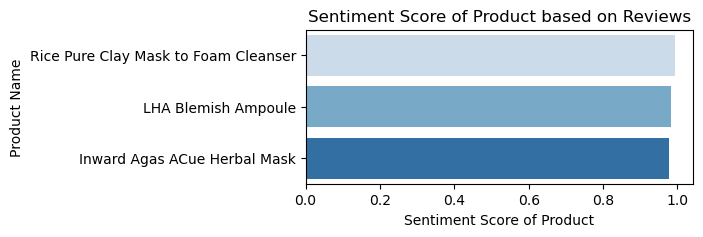

In [54]:
# set figure size
plt.rcParams['figure.figsize'] = (5,2)
sns.color_palette("Blues", as_cmap=True)
sns.barplot(x =plot_df['sentiment_score'],  y= plot_df['product_name'], data = plot_df, palette=("Blues"))

plt.xlabel("Sentiment Score of Product")
plt.ylabel("Product Name")
plt.title("Sentiment Score of Product based on Reviews")
# Show the plot
plt.show()

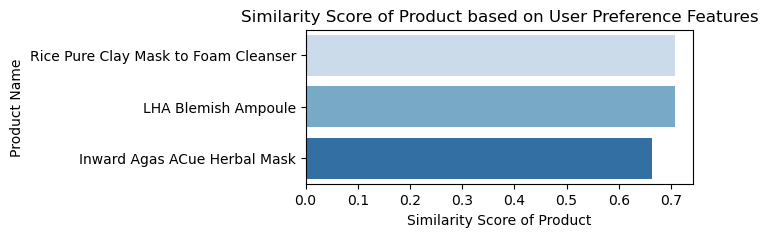

In [55]:
# set figure size
plt.rcParams['figure.figsize'] = (5,2)
sns.color_palette("Blues", as_cmap=True)
sns.barplot(x =plot_df['similarity_score'],  y= plot_df['product_name'], data = plot_df, palette=("Blues"))

plt.xlabel("Similarity Score of Product")
plt.ylabel("Product Name")
plt.title("Similarity Score of Product based on User Preference Features")
# Show the plot
plt.show()

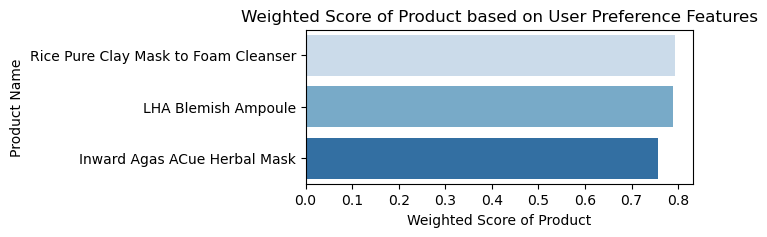

In [56]:
# set figure size
plt.rcParams['figure.figsize'] = (5,2)
sns.color_palette("Blues", as_cmap=True)
sns.barplot(x =plot_df['weighted_score'],  y= plot_df['product_name'], data = plot_df, palette=("Blues"))

plt.xlabel("Weighted Score of Product")
plt.ylabel("Product Name")
plt.title("Weighted Score of Product based on User Preference Features")
# Show the plot
plt.show()

In [57]:
#to check if the feature exist
#x = "hydration" in cv_dataframe

List of User preference

In [58]:
Skin_Concern = ["acne", "anti-aging", "hydration","clogged Pores", "pigmentation", "sensitive", "redness", "uneven skintone", "dryness"]
Product_Type = ["Cleanser", "Mask", "Toner", "Moisturizer,Serum","Other/Spot Treatments","Essence",
                "Sheet Mask","Eye Treatment","Sun Protection","Exfoliator","Lip Treatment"]
Skin_Type = ["oily", "dry", "combination", "normal"]
Price_Range = ["$0-$20", "$21-$40", "$41-$60", "$61-$80", "$81-$100", "Above $100"]
Preference = ["unclogged pores", "minimize pores", "reduce fine lines", "skin glow", "soft skin", "hydration", "detox", "smooth skin", "skinbrightening"]

In [51]:
cosine_similarity

0.816496580927726